In [1]:
%load_ext autoreload
%autoreload 2
import os
from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from signal_utils_1D import *
from plot_utils_1D import *
from jax import random
from scipy.special import j1


def incoherent_psf_1d(wavelength, na, x_range):
    """
    Generate the 1D sinc^2 PSF for an incoherent imaging system.

    Parameters:
    wavelength (float): Wavelength of the light (in units consistent with x_range).
    na (float): Numerical aperture of the imaging system.
    x_range (array-like): Spatial coordinates in the image plane.

    Returns:
    psf (array-like): The 1D sinc^2 PSF evaluated at the given spatial coordinates.
    """
    x = np.asarray(x_range)
    
    # Normalize the input
    norm_x = (2 * np.pi / wavelength) * na * x
    
    # Calculate the sinc^2 pattern
    psf = np.sinc(norm_x / np.pi) ** 2
    
    # Normalize
    psf /= np.sum(psf)
    
    return psf


def nyquist_pixel_size(wavelength, na):
    """
    Calculate the size of a Nyquist-sampled pixel for the sinc function PSF.

    Parameters:
    wavelength (float): Wavelength of the light (in units consistent with the pixel size).
    na (float): Numerical aperture of the imaging system.

    Returns:
    pixel_size (float): The maximum size of a Nyquist-sampled pixel.
    """
    # pixel_size = wavelength / (4 * na)
    pixel_size = wavelength / (32 * na)

    return pixel_size

def make_one_point_object(signal_length):
    one_point_object = onp.zeros(signal_length)
    one_point_object[signal_length//2] = 1
    return np.array(one_point_object)

def make_two_point_object(signal_length, seperation_distance):
    two_point_object = onp.zeros(signal_length)
    two_point_object[signal_length//2 - int(seperation_distance/2)] += 0.5
    two_point_object[signal_length//2 + int(seperation_distance/2)] += 0.5
    return np.array(two_point_object)

get_noisy_measurements = lambda noiseless, snr, num_measurements: noiseless + (1 / (snr * noiseless.size)) * random.normal(
                                   random.PRNGKey(onp.random.randint(10000)), (num_measurements, noiseless.size), np.float32)

def gmm_mean_nll(X, means, covs, weights):
    """
    Compute the mean negative log-likelihood of data points X under a Gaussian Mixture Model
    with given means, covariance matrices, and weights.
    """
    n_components = len(means)
    
    # Compute log probabilities for each component and weight them
    log_likelihoods = np.array([np.log(weights[i]) + jax.scipy.stats.multivariate_normal.logpdf(X, mean=means[i], cov=covs[i])
                                 for i in range(n_components)])

    # Use logsumexp for numerical stability
    total_log_likelihood = jax.scipy.special.logsumexp(log_likelihoods, axis=0)

    return -np.mean(total_log_likelihood)

def estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=int(1e6)):
    gaussian_noise_sigma = 1 / (snr * one_point_noiseless_pixels.size)
    num_pixels = one_point_noiseless_pixels.size
    noisy_one_point_measurements = get_noisy_measurements(one_point_noiseless_pixels, snr, num_measurements // 2)
    noisy_two_point_measurements = get_noisy_measurements(two_point_noiseless_pixels, snr, num_measurements // 2)

    all_measurements = np.concatenate([noisy_one_point_measurements, noisy_two_point_measurements], axis=0)

    means = [one_point_noiseless_pixels, two_point_noiseless_pixels]
    covs = [np.eye(num_pixels) * gaussian_noise_sigma**2 for _ in means]
    weights = np.array([0.5, 0.5])

    hy_mid_x = (0.5 * np.log(2 * np.pi * np.e * gaussian_noise_sigma**2)) * num_pixels

    h_y = gmm_mean_nll(all_measurements, means, covs, weights)

    mi = (h_y - hy_mid_x) / np.log(2) # convert to bits
    return mi

def simulate_optics(wavelength, NA, num_pixels, seperation_distance):
    dx_per_pixel = 32
    pixel_size = nyquist_pixel_size(wavelength, NA) # nm
    dx = pixel_size / dx_per_pixel
    # convert seperation distance to dx steps
    seperation_steps = seperation_distance / dx
    signal_length = num_pixels * dx_per_pixel
    spatial_extent = int(pixel_size * num_pixels)
    x = np.linspace(0, spatial_extent, signal_length)

    psf = incoherent_psf_1d(wavelength, NA, np.linspace(-spatial_extent, spatial_extent, 2*signal_length))

    one_point_object = make_one_point_object(signal_length)
    two_point_object = make_two_point_object(signal_length, seperation_steps)

    # convolve the objects with the sinc kernel
    one_point_convolved = np.convolve(one_point_object, psf, mode='valid')[:-1]
    two_point_convolved = np.convolve(two_point_object, psf, mode='valid')[:-1]

    # bin the convolved objects into pixels
    one_point_noiseless_pixels = one_point_convolved.reshape(num_pixels, dx_per_pixel).sum(axis=1)
    two_point_noiseless_pixels = two_point_convolved.reshape(num_pixels, dx_per_pixel).sum(axis=1)

    cropped_PSF = psf[signal_length//2:-signal_length//2]
    return one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, cropped_PSF

def make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, num_pixels, snr):
  # create noisy measurements
  one_point_noisy_measurement = get_noisy_measurements(one_point_noiseless_pixels, snr, 1).flatten()
  two_point_noisy_measurement = get_noisy_measurements(two_point_noiseless_pixels, snr, 1).flatten()
  
  fig, ax = plt.subplots(1, 3, figsize=(12, 4))
  # plot the convolved objects
  ax[0].plot(x, one_point_convolved)
  ax[0].plot(x, two_point_convolved)
  ax[0].set(title='Convolved Objects', xlim=(x.min(), x.max()), ylim=(0, one_point_convolved.max()), 
            yticks=[0, one_point_convolved.max()], xlabel='Position (nm)', ylabel='Intensity')

  # plot the pixelated objects
  ymax = 1.1 * max(one_point_noisy_measurement.max(), two_point_noisy_measurement.max()) 
  ax[1].plot(np.arange(num_pixels), one_point_noiseless_pixels, drawstyle='steps-mid')
  ax[1].plot(np.arange(num_pixels), two_point_noiseless_pixels, drawstyle='steps-mid')
  ax[1].set(title='Pixelated clean signals', xlim=(0, num_pixels), ylim=(0, ymax), 
            yticks=[0, ymax], xlabel='Pixel', ylabel='Intensity')

  # plot noisy measurements
  gaussian_noise_sigma = 1 / (snr * num_pixels) 
  ax[2].plot(one_point_noisy_measurement, drawstyle='steps-mid', label='one point')
  ax[2].plot(two_point_noisy_measurement, drawstyle='steps-mid', label='two point')
  ax[2].set(title='Noisy Measurements', xlim=(0, num_pixels), ylim=(0, ymax), 
                yticks=[], xlabel='Pixel')
  ax[2].legend()

  _ = [clear_spines(ax[i]) for i in range(len(ax))]


2024-04-16 10:31:41.247307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


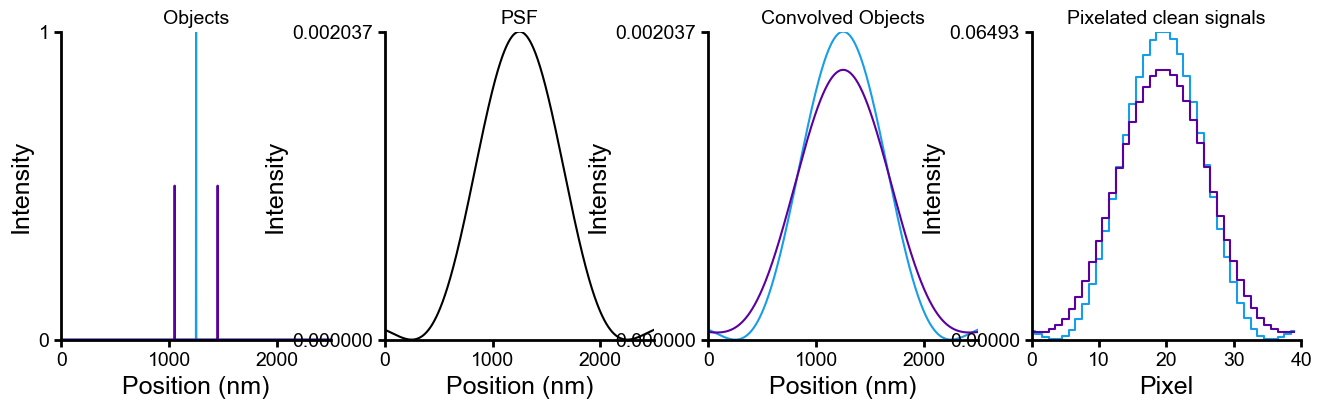

In [5]:
wavelength = 400 # nm
NA = 0.2
num_pixels = 40
seperation_distance = 400 # nm

# rayleigh_dist = wavelength / (2*NA)
# seperation_distance = rayleigh_dist
# print(f"Rayleigh distance: {rayleigh_dist} nm")

(one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
  x, PSF) = simulate_optics(wavelength, NA, num_pixels, seperation_distance)


###### Make plots ###### 
# plot both objects
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].plot(x, one_point_object)
ax[0].plot(x, two_point_object)
ax[0].set(title='Objects', xlim=(x.min(), x.max()), ylim=(0, 1), yticks=[0, 1], xlabel='Position (nm)', ylabel='Intensity')

# plot the PSF
ax[1].plot(x, PSF, 'k-')
ax[1].set(title='PSF', xlim=(x.min(), x.max()), ylim=(0, PSF.max()), yticks=[0, PSF.max()], xlabel='Position (nm)', ylabel='Intensity')

# plot the convolved objects
ax[2].plot(x, one_point_convolved)
ax[2].plot(x, two_point_convolved)
ax[2].set(title='Convolved Objects', xlim=(x.min(), x.max()), ylim=(0, one_point_convolved.max()), 
          yticks=[0, one_point_convolved.max()], xlabel='Position (nm)', ylabel='Intensity')

# plot the pixelated objects
ax[3].plot(np.arange(num_pixels), one_point_noiseless_pixels, drawstyle='steps-mid')
ax[3].plot(np.arange(num_pixels), two_point_noiseless_pixels, drawstyle='steps-mid')
ax[3].set(title='Pixelated clean signals', xlim=(0, num_pixels), ylim=(0, one_point_noiseless_pixels.max()), 
          yticks=[0, one_point_noiseless_pixels.max()], xlabel='Pixel', ylabel='Intensity')
_ = [clear_spines(ax[i]) for i in range(4)]

# Estimate the MI of noisy measurements

Estimated MI: 0.9758 bits


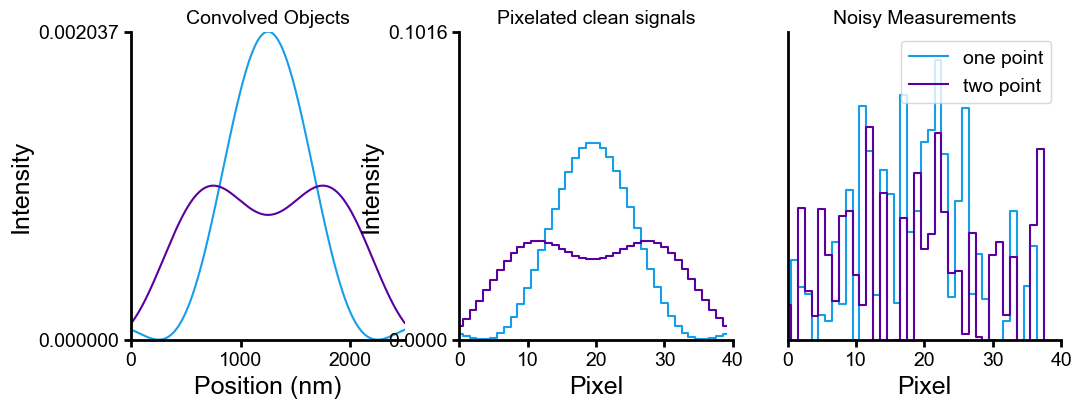

In [3]:

num_measurements = int(1e6)
snr = 1

make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels, x, num_pixels, snr)

mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr=snr, num_measurements=num_measurements)
print(f"Estimated MI: {mi:.4f} bits")

### Sample size vs estimate

In [4]:
# Look at sample size dependence of estimate
nums_to_use = np.logspace(1, 7, 10, base=10).astype(int)
mis = []

for num_to_use in tqdm(nums_to_use):
    mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_to_use)
    mis.append(mi)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogx(nums_to_use, mis, 'o-')

print(f"Estimated MI: {mi:.3f} bits")

  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'gaussian_noise_sigma' is not defined

## Do Information vs SNR and NA



In [4]:
# SNRs = np.linspace(2, 0.1, 20)
SNRs = np.logspace(-2, 0, 21)
NAs = np.linspace(0.2, 1.2, 21) 

num_measurements = int(1e5)

wavelength = 400 # nm
num_pixels = 120
seperation_distance = 300 # nm

results = onp.zeros((len(SNRs), len(NAs)))
for i, snr in tqdm(enumerate(SNRs)):
    for j, na in enumerate(NAs):
        (one_point_object, two_point_object, one_point_convolved, two_point_convolved, one_point_noiseless_pixels, two_point_noiseless_pixels,
          x, PSF) = simulate_optics(wavelength, na, num_pixels, seperation_distance)
        mi = estimate_2_point_1_point_mi(one_point_noiseless_pixels, two_point_noiseless_pixels, snr, num_measurements=num_measurements)
        results[i, j] = mi

results = np.array(results)

21it [00:45,  2.15s/it]


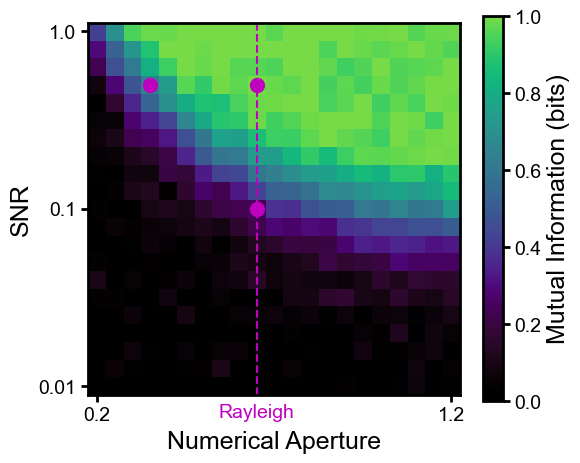

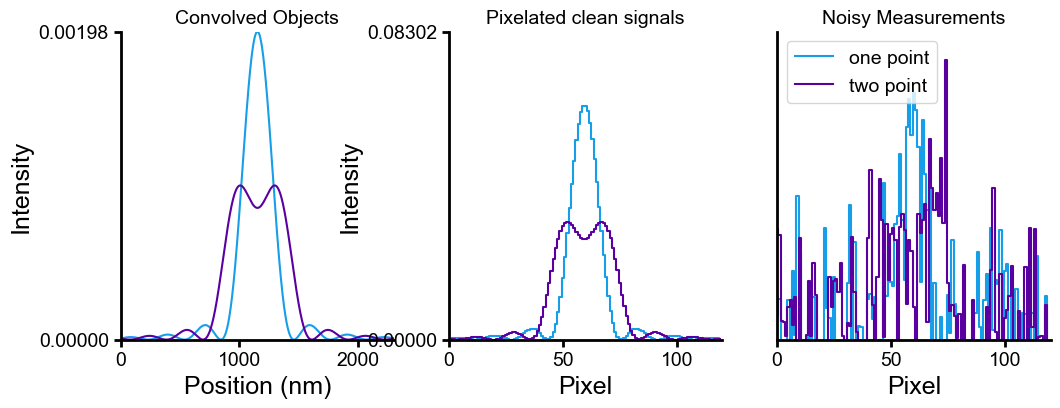

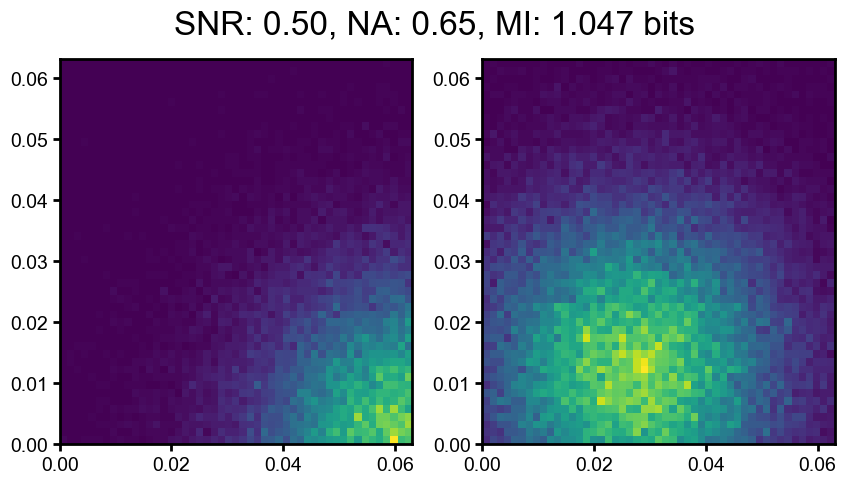

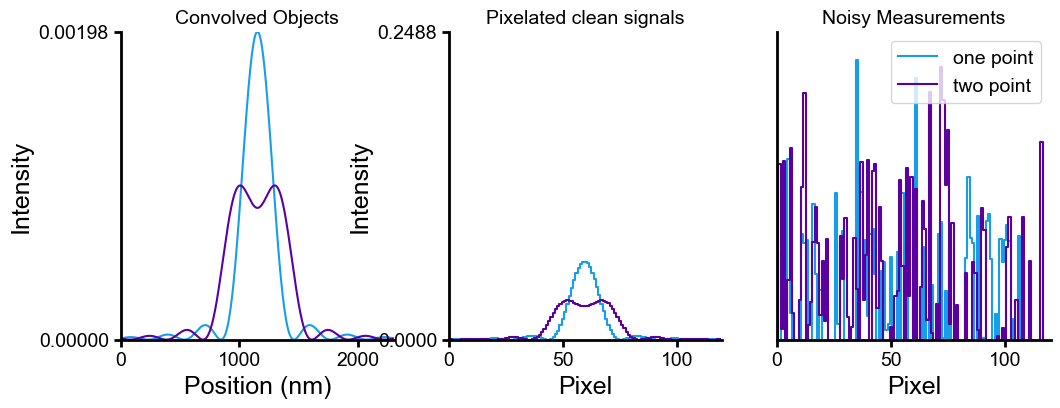

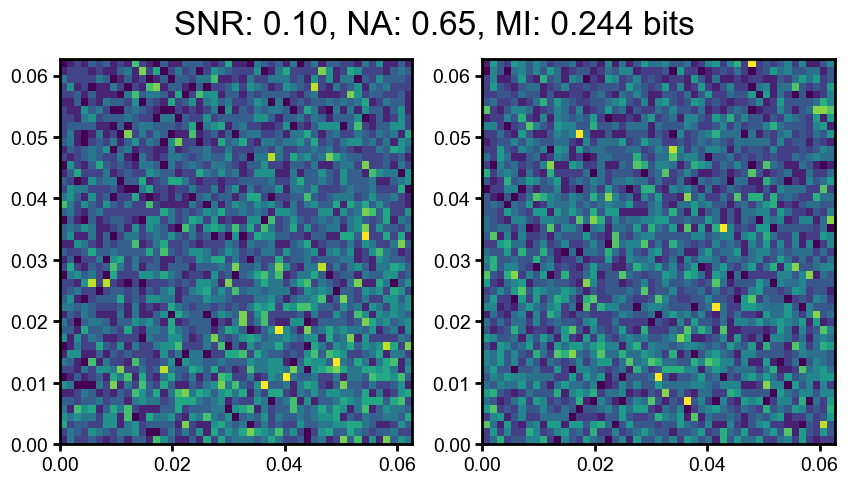

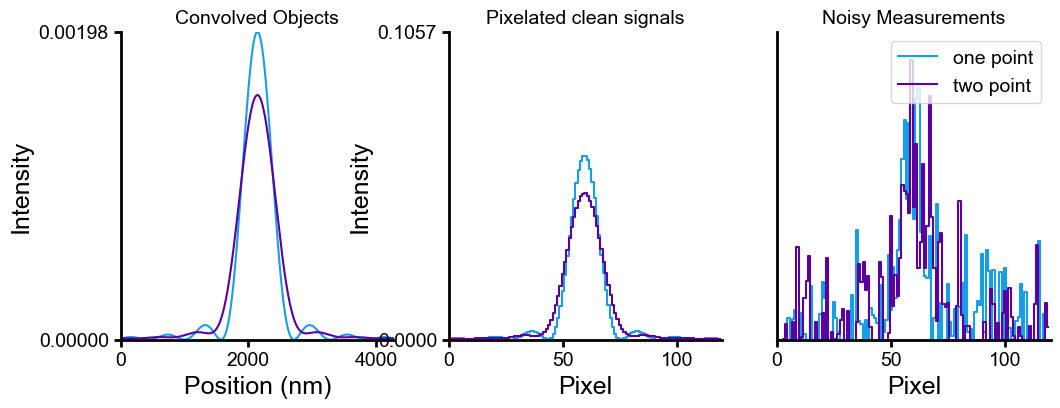

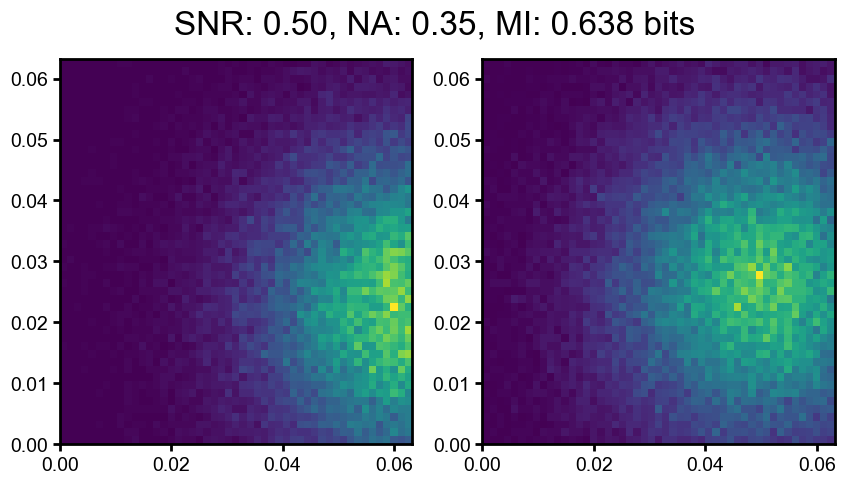

In [5]:
# make plot
import cmasher as cmr
from matplotlib.ticker import LogLocator, LogFormatter

cmap = cmr.lavender

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
cax = ax.imshow(results, cmap=cmap, origin='lower', vmin=0, vmax=1,)
            #      extent=[NAs[0], NAs[-1], SNRs[0], SNRs[-1]],
            # aspect= (NAs[-1] - NAs[0]) / (SNRs[-1] - SNRs[0]))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Mutual Information (bits)')


_ = ax.set(xlabel='Numerical Aperture', ylabel='SNR',
        xticks=[0, len(NAs) - 1], xticklabels=[NAs[0], NAs[-1]],
        yticks=[0, len(SNRs) // 2, len(SNRs) - 1], 
        yticklabels=[SNRs[0], SNRs[len(SNRs) // 2], SNRs[-1]])


def make_intenisty_coord_plot(wavelength, NA_value, num_pixels, seperation_distance, snr):
    num_noisy_measurements = int(1e5)
    
    (one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
     one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, 
                                                                                       num_pixels, seperation_distance)
    center_pixel_index = num_pixels // 2
    dx_per_pixel = one_point_object.size // num_pixels
    seperation_distance_pixels = int(np.round(seperation_distance / (x[1] - x[0]) / dx_per_pixel))

    one_point_noisy_measurements = get_noisy_measurements(one_point_noiseless_pixels, snr, num_noisy_measurements)
    x1_one_point = one_point_noisy_measurements[:, center_pixel_index]
    x2_one_point = one_point_noisy_measurements[:, center_pixel_index + seperation_distance_pixels]

    two_point_noisy_measurements = get_noisy_measurements(two_point_noiseless_pixels, snr, num_noisy_measurements)
    x1_two_point = two_point_noisy_measurements[:, center_pixel_index]
    x2_two_point = two_point_noisy_measurements[:, center_pixel_index + seperation_distance_pixels]

    # plot hist2d

    # TODO: get the color histrogram blending code



    

    bin_max = max(x1_one_point.mean(), x2_one_point.mean(), x1_two_point.mean(), x2_two_point.mean())
    bins_x1 = np.linspace(0, bin_max, 50)
    bins_x2 = np.linspace(0, bin_max, 50)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hist2d(x1_one_point, x2_one_point, bins=[bins_x1, bins_x2], cmap='viridis')
    ax[1].hist2d(x1_two_point, x2_two_point, bins=[bins_x1, bins_x2], cmap='viridis')


def add_point(SNR_value, NA_value):
    # Find the indices from the values, this is necessary for simulation and result extraction
    SNR_index = np.argmin(np.abs(SNRs - SNR_value))
    NA_index = np.argmin(np.abs(NAs - NA_value))

    # now replace the values with the ones we have data for
    SNR_value = SNRs[SNR_index]
    NA_value = NAs[NA_index]
    
    # Retrieve simulation details using indices if necessary
    (one_point_object, two_point_object, one_point_convolved, two_point_convolved, 
     one_point_noiseless_pixels, two_point_noiseless_pixels, x, PSF) = simulate_optics(wavelength, NA_value, 
                                                                                       num_pixels, seperation_distance)
    make_signal_and_measurement_plot(one_point_convolved, two_point_convolved, one_point_noiseless_pixels, 
                                     two_point_noiseless_pixels, x, num_pixels, SNR_value)
    
    make_intenisty_coord_plot(wavelength, NA_value, num_pixels, seperation_distance, SNR_value)

    plt.gcf().suptitle(f"SNR: {SNR_value:.2f}, NA: {NA_value:.2f}, MI: {results[SNR_index, NA_index]:.3f} bits")

    # Plot the point using the actual SNR and NA values
    ax.plot(NA_index, SNR_index, 'mo', markersize=10)
    


# compute NA that gives the Rayleigh distance for this seperation distance
rayleigh_na = wavelength / (2 * seperation_distance)
# make a dotted line at the Rayleigh NA
ax.axvline(np.argmin(np.abs(NAs - rayleigh_na)), color='m', linestyle='--')
# add label on the x axis
ax.text(np.argmin(np.abs(NAs - rayleigh_na)), -1, f'Rayleigh', color='m', ha='center', va='top')

add_point(SNR_value=0.5, NA_value=rayleigh_na)


add_point(SNR_value=0.1, NA_value=rayleigh_na)


add_point(SNR_value=0.5, NA_value=rayleigh_na / 2)



In [ ]:
# make an intensity coord plot for the center pixel and centered on one of the other two peaks

